In [1]:
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np
import hdbscan
import datetime
import seaborn as sns
import sklearn

In [4]:
orders = pd.read_csv('Orders_Table.csv',sep=';').drop(columns = 'Unnamed: 0')
customer = pd.read_csv('Customer_Code.csv', sep=';')
dico_customer = dict(zip(customer['Customer Id'], customer['Customer Segment']))
orders['Customer Segment'] = orders['Order Customer Id'].map(dico_customer)

orders['order date (DateOrders)'] = pd.to_datetime(orders['order date (DateOrders)'])
product_id = pd.read_csv('Product_Id.csv',sep = ';')
category_id = pd.read_csv('Category_Id.csv', sep = ';')

dico_product = dict(zip(category_id['Category Id'], category_id['Category Name']))
dico_category = dict(zip(category_id['Category Name'].unique(), range(len(category_id['Category Name'].unique()))))

product_id['Category Name'] = product_id['Product Category Id'].map(dico_product)
product_id['Category Name Num'] = product_id['Category Name'].map(dico_category)

dico_product_class = dict(zip(product_id['Product Card Id'], product_id['Category Name']))

orders['Product Class'] = orders['Order Item Cardprod Id'].map(dico_product_class)
orders['PnL'] = orders['Order Profit'].apply(lambda x : 'Profit' if x >= 0 else 'Loss')
orders['Abs Profit'] = orders['Order Profit'].abs()

ts = orders.sort_values(by = ['Order Customer Id', 'order date (DateOrders)'])
profit_sum = pd.pivot_table(
                ts,
                values = 'Abs Profit',
                index = ['Order Customer Id'],
                columns = ['Customer Segment', 'Product Class', 'PnL'],
                aggfunc = ['sum'],
                fill_value = 0
                )

profit_sum.columns = ['_'.join(map(str, col)) for col in profit_sum.columns]
profit_sum_normed = profit_sum.div(profit_sum.sum(axis=1), axis=0).loc[:, (profit_sum != 0).any(axis = 0)]
profit_sum_normed 

,sum_Consumer_Accessories_Loss,sum_Consumer_Accessories_Profit,sum_Consumer_As Seen on TV!_Loss,sum_Consumer_As Seen on TV!_Profit,sum_Consumer_Baby _Loss,sum_Consumer_Baby _Profit,sum_Consumer_Baseball & Softball_Loss,sum_Consumer_Baseball & Softball_Profit,sum_Consumer_Basketball_Loss,sum_Consumer_Basketball_Profit,...,sum_Home Office_Video Games_Loss,sum_Home Office_Video Games_Profit,sum_Home Office_Water Sports_Loss,sum_Home Office_Water Sports_Profit,sum_Home Office_Women's Apparel_Loss,sum_Home Office_Women's Apparel_Profit,sum_Home Office_Women's Clothing_Loss,sum_Home Office_Women's Clothing_Profit,sum_Home Office_Women's Golf Clubs_Loss,sum_Home Office_Women's Golf Clubs_Profit
Order Customer Id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.031739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20754,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20755,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


UMAP(low_memory=False, n_neighbors=100, random_state=42, verbose=True)
Wed Mar  9 16:20:47 2022 Construct fuzzy simplicial set
Wed Mar  9 16:20:47 2022 Finding Nearest Neighbors
Wed Mar  9 16:20:47 2022 Building RP forest with 12 trees
Wed Mar  9 16:20:48 2022 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Wed Mar  9 16:21:15 2022 Finished Nearest Neighbor Search
Wed Mar  9 16:21:17 2022 Construct embedding



Wed Mar  9 16:22:42 2022 Finished embedding


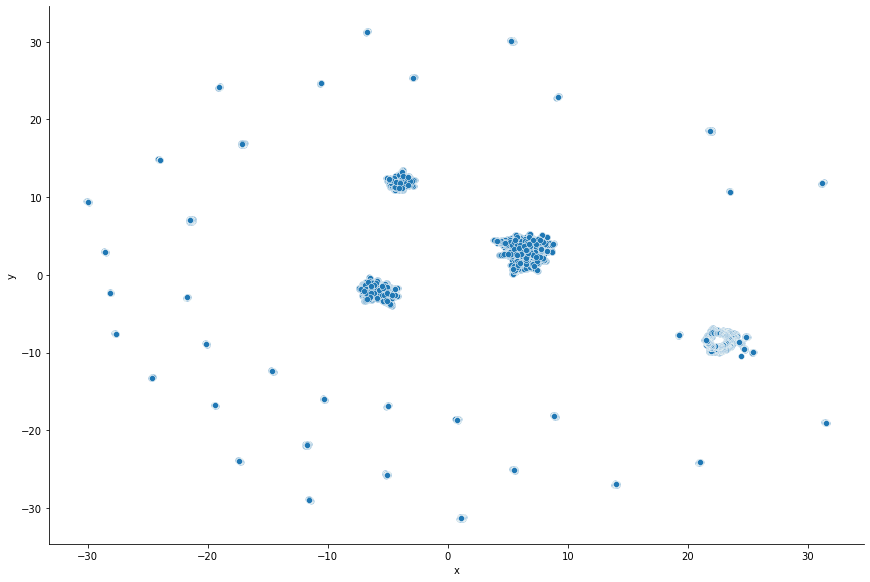

In [5]:
n_neighbors = 100
min_dist = 0.1
n_components = 2
metric = 'euclidean'

def umap_function(data):
    reducer = umap.UMAP(
                        n_neighbors = n_neighbors,
                        min_dist = min_dist,
                        n_components = n_components,
                        metric = metric,
                        low_memory = False,
                        verbose = True,
                        random_state = 42
    )
    reducer = reducer.fit(data)
    embedding_2d_cluster = reducer.transform(data)
    embedding_2d_cluster = pd.DataFrame(embedding_2d_cluster, index = data.index, columns = ['x','y'])
    
    sns.relplot(data = embedding_2d_cluster, x='x', y='y', height = 8, aspect = 1.5)
    plt.show()
    
    return embedding_2d_cluster, reducer

embedding_2d_cluster, reducer = umap_function(profit_sum_normed.fillna(0))

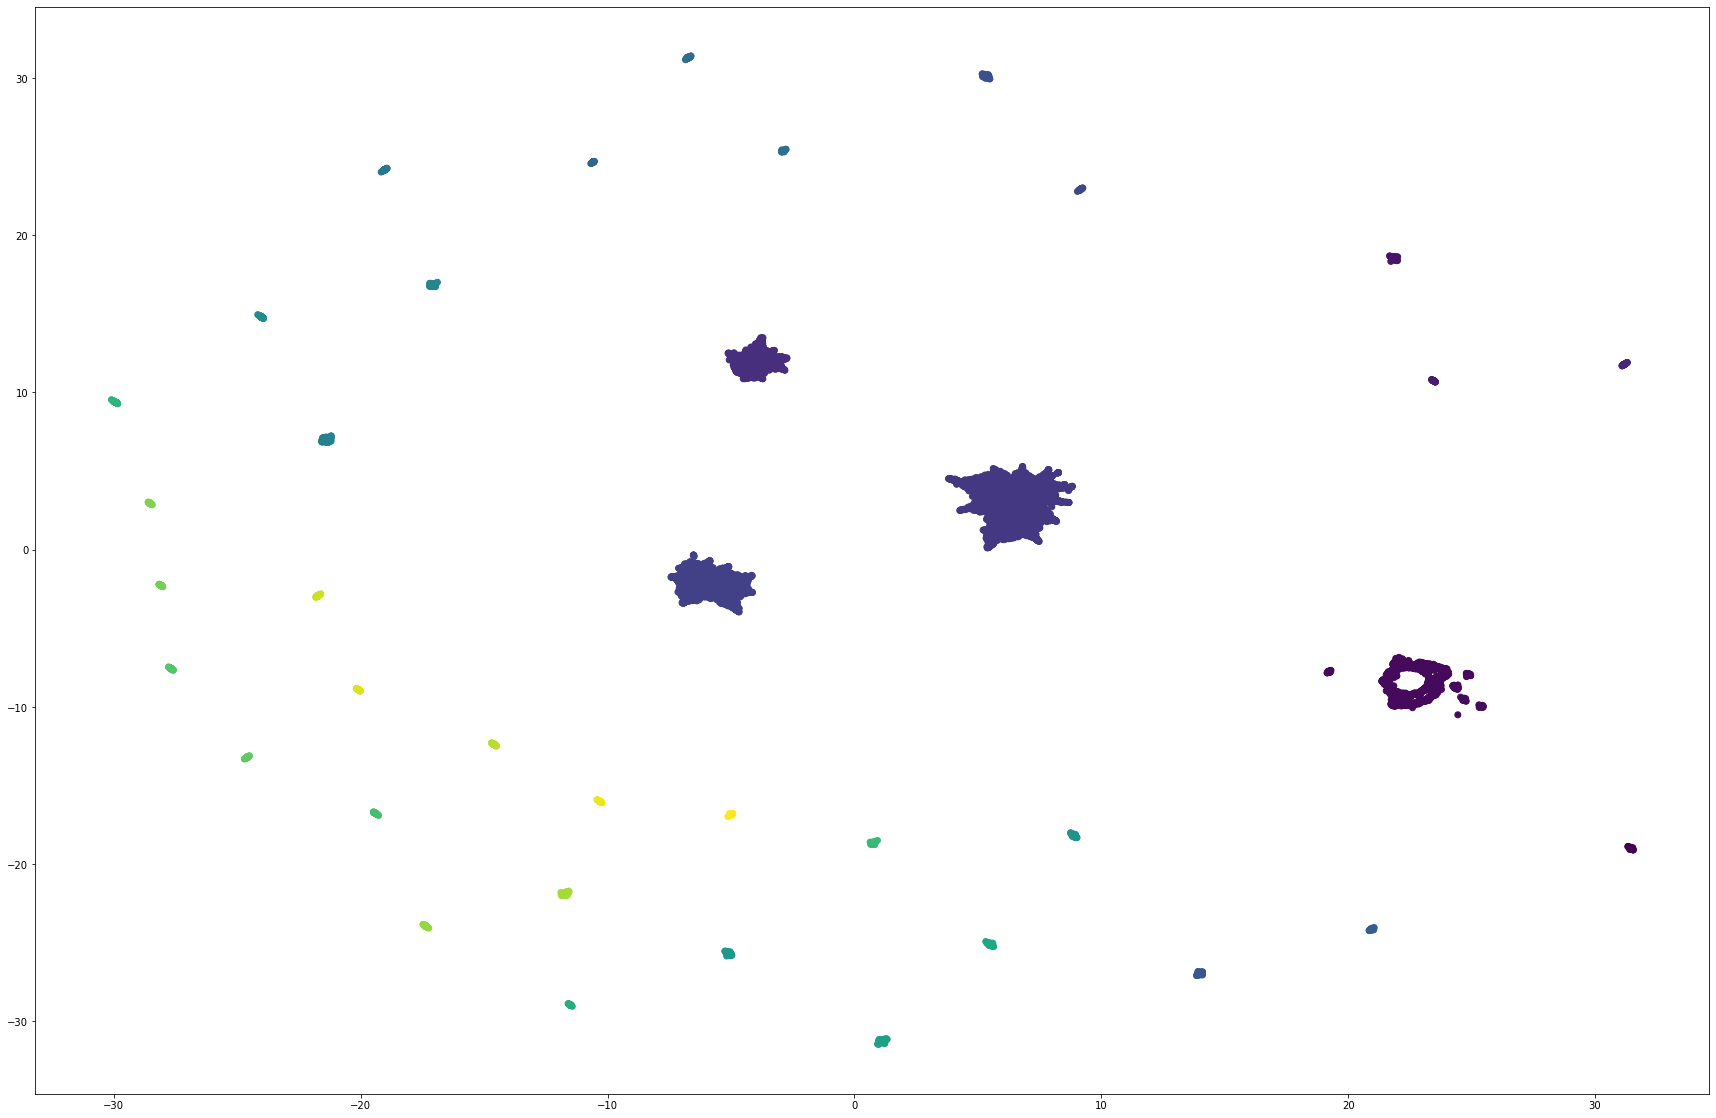

In [6]:
hdbscan_labels = hdbscan.HDBSCAN(min_samples=100, min_cluster_size=50).fit_predict(embedding_2d_cluster)
plt.figure(figsize = (30,20))
plt.scatter(embedding_2d_cluster['x'], embedding_2d_cluster['y'], c = hdbscan_labels)

In [16]:
data_cluster = profit_sum_normed.copy()
data_cluster['cluster'] = hdbscan_labels

,sum_Consumer_Accessories_Loss,sum_Consumer_Accessories_Profit,sum_Consumer_As Seen on TV!_Loss,sum_Consumer_As Seen on TV!_Profit,sum_Consumer_Baby _Loss,sum_Consumer_Baby _Profit,sum_Consumer_Baseball & Softball_Loss,sum_Consumer_Baseball & Softball_Profit,sum_Consumer_Basketball_Loss,sum_Consumer_Basketball_Profit,...,sum_Home Office_Video Games_Profit,sum_Home Office_Water Sports_Loss,sum_Home Office_Water Sports_Profit,sum_Home Office_Women's Apparel_Loss,sum_Home Office_Women's Apparel_Profit,sum_Home Office_Women's Clothing_Loss,sum_Home Office_Women's Clothing_Profit,sum_Home Office_Women's Golf Clubs_Loss,sum_Home Office_Women's Golf Clubs_Profit,cluster
Order Customer Id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
4,0.0,0.031739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
20754,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
20755,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11


In [48]:
for clus in list(data_cluster.cluster.unique()):
    cluster_index = data_cluster[data_cluster.cluster == clus].index
    print(orders[orders['Order Customer Id'].isin(cluster_index)]['Order Profit'].mean()/orders[orders['Order Customer Id'].isin(cluster_index)]['Order Profit'].var())

0.002182444324399176
0.002273651559120737
0.0022921876058625487
-0.0007775326468896579
0.5291016767950366
0.4521034945863025
1.409406506456488
0.0349756495418853
0.03961859832146941
0.04402078063742094
0.04484310796211524
0.013285427159335405
0.010246682468462187
0.060276033152720836
0.06962327905331461
0.032828578529613725
0.03801564325829496
0.1031429831375522
0.10663702269651193
0.028141094663793324
0.03671453031451545
0.04806733545749204
0.06347141501920213
0.05282245891129969
0.06723638221313138
0.18493394166582505
0.1852608343819014
0.04727551518100713
0.05003760776618811
1.3318033108378118
1.485092568584411
1.1222339056315083
0.4024987474181597
0.34893826422549334
0.45803036446733314
0.07164793916166366
0.08913488138737705
0.06866661220330265


# Profit Impact Analysis

## Overall Profit

In [50]:
orders.columns

Index(['Order Id', 'Order Item Cardprod Id', 'Order Customer Id',
       'Order Department Id', 'Market', 'Order City', 'Order Country',
       'Order Region', 'Order State', 'Order Status', 'Order Zipcode',
       'order date (DateOrders)', 'Order Item Discount',
       'Order Item Discount Rate', 'Order Item Id', 'Order Item Quantity',
       'Sales', 'Order Item Total', 'Order Profit', 'Type',
       'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Delivery Status', 'Late Delivery Risk', 'Customer Segment',
       'Product Class', 'PnL', 'Abs Profit'],
      dtype='object')

<AxesSubplot:>

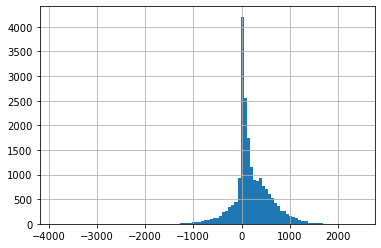

In [54]:
orders.groupby('Order Customer Id').sum()['Order Profit'].hist(bins=100)